# How To Implement Working Memory in AI Applications With Cohere, Tavily and MongoDB

<a href="https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/implementing_working_memory_with_tavily_and_mongodb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memory is the cornerstone on which all forms of intelligence emerge and evolve. It creates the foundation for human cognition and artificial systems to build complex understanding. For humans, memory is a dynamic biological process of encoding, storing, and retrieving information through neural networks, shaping our ability to learn, adapt, and make decisions.

For computational systems in the modern AI application landscape, such as LLM-powered chatbots,  AI Agents, and Agentic systems, memory is the foundation for their reliability, performance, and applicability, determining their capacity to maintain context, learn from interactions, and exhibit consistent, intelligent behavior.

In this tutorial, we will cover:
- Memory in AI Agents and Agentic Systems
- How to implement working memory in agentic systems
- How to use Tavily and MongoDB to implement working memory
- A practical use case: implementing an AI sales assistant with real-time access to internal product catalogs and online information, showcasing working memory's role in personalized recommendations and user interactions.
- Benefits of working memory in AI applications in real-time scenarios.

Your ability to understand memory from a holistic perspective and the ability to implement various functionalities of memory within computational systems positions you at a critical intersection of cognitive architecture design and practical AI development, making your expertise invaluable as these paradigms increase and become the dominant form factor of modern AI systems.


## Install libaries and set environment variables

In [1]:
!pip install --quiet --upgrade tavily-python cohere pymongo datasets pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curren

In [2]:
import os
import getpass


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

# Step 1 - 5: Creating a knowledge base (long-term memory)

In this step, the aim is to create a knowledge base consisting of a product accessible by the research assistant via retrieval mechanisms. The retrieval mechanism used in this tutorial is vector search. MongoDB is used as an operational and vector database for the sales assistant's knowledge base. This means we can conduct a semantic search between the vector embeddings of each product generated from concatenated existing product attributes and an embedding of a user’s query passed into the assistant.


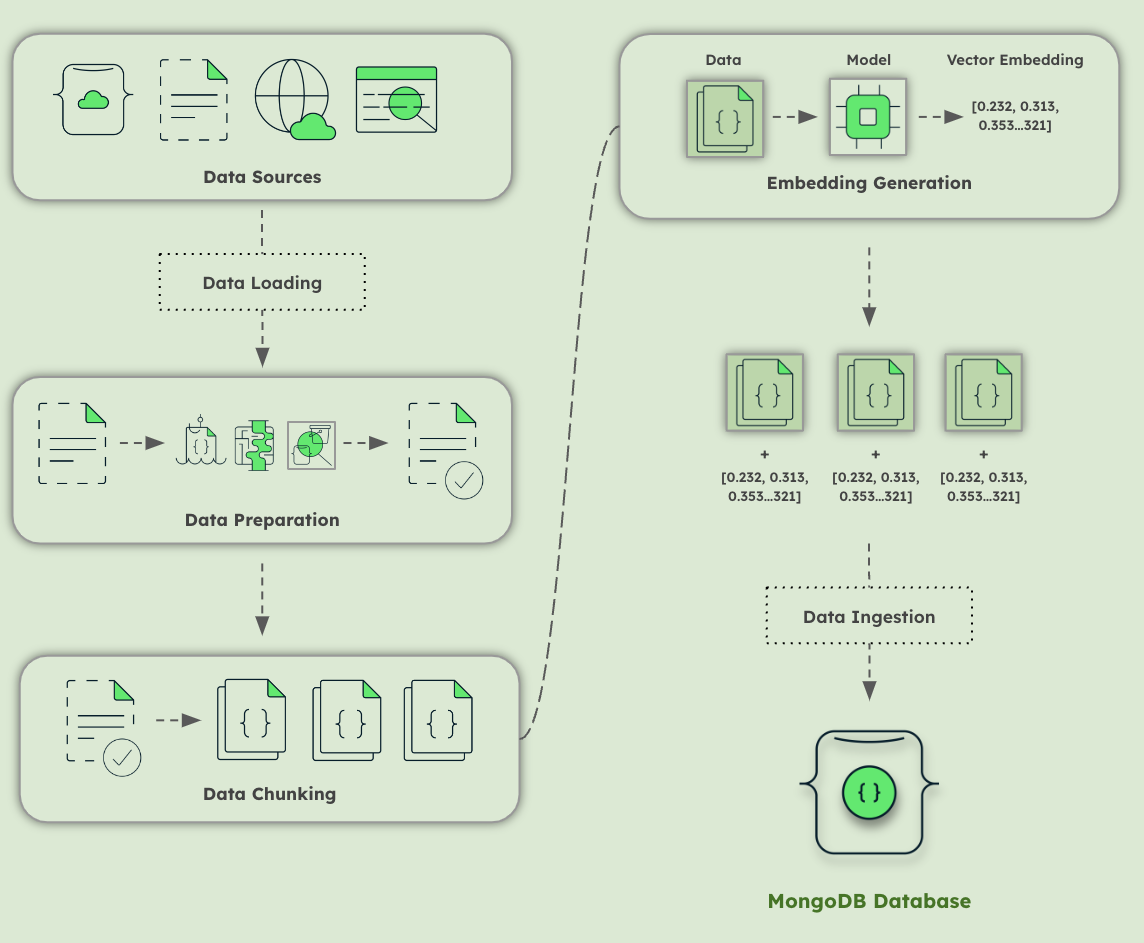

## Step 1: Data Loading

The process begins with data ingestion into MongoDB. The product data, including attributes like product name, category, description, and technical details, is structured into a pandas DataFrame.

The product data used in this example is sourced from the Hugging Face Datasets library using the `load_dataset()` function. Specifically, it is obtained from the "philschmid/amazon-product-descriptions-vlm" dataset, which contains a vast collection of Amazon product descriptions and related information.


In [3]:
from datasets import load_dataset
import pandas as pd

# Make sure you have an HF_TOKEN in your environment varibales to access dataset on hugging face
product_dataset = load_dataset("philschmid/amazon-product-descriptions-vlm")

# Convert product_dataset to pandas dataframe
product_dataframe = pd.DataFrame(product_dataset["train"])

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

In [4]:
# Display top 5 rows
product_dataframe.head()

,image,Uniq Id,Product Name,Category,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Variants,Product Url,Is Amazon Seller,description
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,002e4642d3ead5ecdc9958ce0b3a5a79,"Kurio Glow Smartwatch for Kids with Bluetooth,...",Toys & Games | Kids' Electronics | Electronic ...,$31.30,C17515,Make sure this fits by entering your model num...,ProductDimensions:5x3x12inches|ItemWeight:7.2o...,Color:Blue show up to 2 reviews by default Thi...,7.2 ounces,https://www.amazon.com/Kurio-Smartwatch-Blueto...,https://www.amazon.com/Kurio-Smartwatch-Blueto...,Y,"Kurio Glow Smartwatch: Fun, Safe & Educational..."
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,009359198555dde1543d94568183703c,Star Ace Toys Harry Potter & The Prisoner of A...,None,$174.99,SA8011B,Make sure this fits by entering your model num...,ProductDimensions:2.5x1x9inches|ItemWeight:1.4...,From Star Ace Toys. Many fans would say that H...,1.43 pounds,None,https://www.amazon.com/Star-Ace-Toys-Prisoner-...,Y,Relive the magic! Star Ace Toys' 1/8 scale Ha...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,00cb3b80482712567c2180767ec28a6a,Barbie Fashionistas Doll Wear Your Heart,Toys & Games | Dolls & Accessories | Dolls,$15.99,FJF44,Make sure this fits by entering your model num...,ProductDimensions:2.1x4.5x12.8inches|ItemWeigh...,Go to your orders and start the return Select ...,4.2 ounces,None,https://www.amazon.com/Barbie-FJF44-Love-Fashi...,Y,Express your style with Barbie Fashionistas Do...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,00cce525ebf9181ebfba30dc5ca936fd,Redcat Racing Aluminum Rear Lower Suspension A...,Toys & Games | Hobbies | Remote & App Controll...,$14.40,06049B,"Aluminum Rear Lower Suspension Arms, Blue (2pc...",ProductDimensions:1.5x3.5x0.2inches|ItemWeight...,2.4 ounces (View shipping rates and policies) ...,2.4 ounces,None,https://www.amazon.com/Redcat-Racing-Aluminum-...,Y,Upgrade your Redcat Racing vehicle's performan...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,015cc42a8e93b15bcea9425d63ecbbd9,"Tru-Ray Heavyweight Construction Paper Pad, 10...","Arts, Crafts & Sewing | Crafting | Paper & Pap...",$10.10,6592,Make sure this fits by entering your model num...,ASIN:B01ELJGWKW|ShippingWeight:1pounds(Viewshi...,Go to your orders and start the return Select ...,1 pounds,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,Y,Unleash your creativity with Tru-Ray Heavyweig...


## Step 2: Data Preparation

In [5]:
# Create a new coloumn in the dataset that combines existing coloumns that captures a product semantics
product_dataframe["product_semantics"] = product_dataframe.apply(
    lambda row: " ".join(
        str(x)
        for x in [
            row["Product Name"],
            row["Category"],
            row["About Product"],
            row["Technical Details"],
            row["description"],
        ]
        if x
    ),
    axis=1,
)

In [6]:
# Display top 5 data point to see new coloumn
product_dataframe.head()

,image,Uniq Id,Product Name,Category,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Variants,Product Url,Is Amazon Seller,description,product_semantics
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,002e4642d3ead5ecdc9958ce0b3a5a79,"Kurio Glow Smartwatch for Kids with Bluetooth,...",Toys & Games | Kids' Electronics | Electronic ...,$31.30,C17515,Make sure this fits by entering your model num...,ProductDimensions:5x3x12inches|ItemWeight:7.2o...,Color:Blue show up to 2 reviews by default Thi...,7.2 ounces,https://www.amazon.com/Kurio-Smartwatch-Blueto...,https://www.amazon.com/Kurio-Smartwatch-Blueto...,Y,"Kurio Glow Smartwatch: Fun, Safe & Educational...","Kurio Glow Smartwatch for Kids with Bluetooth,..."
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,009359198555dde1543d94568183703c,Star Ace Toys Harry Potter & The Prisoner of A...,None,$174.99,SA8011B,Make sure this fits by entering your model num...,ProductDimensions:2.5x1x9inches|ItemWeight:1.4...,From Star Ace Toys. Many fans would say that H...,1.43 pounds,None,https://www.amazon.com/Star-Ace-Toys-Prisoner-...,Y,Relive the magic! Star Ace Toys' 1/8 scale Ha...,Star Ace Toys Harry Potter & The Prisoner of A...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,00cb3b80482712567c2180767ec28a6a,Barbie Fashionistas Doll Wear Your Heart,Toys & Games | Dolls & Accessories | Dolls,$15.99,FJF44,Make sure this fits by entering your model num...,ProductDimensions:2.1x4.5x12.8inches|ItemWeigh...,Go to your orders and start the return Select ...,4.2 ounces,None,https://www.amazon.com/Barbie-FJF44-Love-Fashi...,Y,Express your style with Barbie Fashionistas Do...,Barbie Fashionistas Doll Wear Your Heart Toys ...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,00cce525ebf9181ebfba30dc5ca936fd,Redcat Racing Aluminum Rear Lower Suspension A...,Toys & Games | Hobbies | Remote & App Controll...,$14.40,06049B,"Aluminum Rear Lower Suspension Arms, Blue (2pc...",ProductDimensions:1.5x3.5x0.2inches|ItemWeight...,2.4 ounces (View shipping rates and policies) ...,2.4 ounces,None,https://www.amazon.com/Redcat-Racing-Aluminum-...,Y,Upgrade your Redcat Racing vehicle's performan...,Redcat Racing Aluminum Rear Lower Suspension A...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,015cc42a8e93b15bcea9425d63ecbbd9,"Tru-Ray Heavyweight Construction Paper Pad, 10...","Arts, Crafts & Sewing | Crafting | Paper & Pap...",$10.10,6592,Make sure this fits by entering your model num...,ASIN:B01ELJGWKW|ShippingWeight:1pounds(Viewshi...,Go to your orders and start the return Select ...,1 pounds,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,Y,Unleash your creativity with Tru-Ray Heavyweig...,"Tru-Ray Heavyweight Construction Paper Pad, 10..."


In [7]:
# We are not using the image data, so let's remove this
product_dataframe = product_dataframe.drop(columns=["image"])

## Step 3: Embedding Generation With Cohere

To facilitate semantic search capabilities, each product document is enriched with embeddings. The `get_embedding()` function utilizes the Cohere API to generate a numerical representation of each product's semantic meaning. This function leverages the `embed-english-v3.0` model from Cohere to embed the combined textual information stored in each document's `product_semantics` field.


In [8]:
# Add Cohere API Key to Environment Variable
set_env_securely("COHERE_API_KEY", "Enter your Cohere API Key: ")

Enter your Cohere API Key: ··········


In [9]:
import cohere

co = cohere.ClientV2()


def get_embedding(texts, model="embed-english-v3.0", input_type="search_document"):
    """Gets embeddings for a list of texts using the Cohere API.

    Args:
      texts: A list of texts to embed.
      model: The Cohere embedding model to use.
      input_type: The input type for the embedding model.

    Returns:
      A list of embeddings, where each embedding is a list of floats.
    """
    try:
        response = co.embed(
            texts=[texts],
            model=model,
            input_type=input_type,
            embedding_types=["float"],
        )
        # Extract and return the embeddings
        return response.embeddings.float[0]
    except Exception as e:
        print(f"Error generating embeddings: {e}")
        print("Couldn't generate emebedding for text: ")
        print(texts)
        return None

In [10]:
# Generate an embedding coloum for each datapoint in the dataset
# Embedding is generated from the new product semantics attribute
try:
    product_dataframe["embedding"] = product_dataframe["product_semantics"].apply(
        get_embedding
    )
    print("Embeddings generated successfully")
except Exception as e:
    print(f"Error generating embeddings: {e}")

Embeddings generated successfully


The resulting embeddings are then stored within a dedicated 'embedding' field in each product document. This step enables the system to search for products based on their semantic similarity, allowing for more nuanced and relevant recommendations.


In [11]:
product_dataframe.head()

,Uniq Id,Product Name,Category,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Variants,Product Url,Is Amazon Seller,description,product_semantics,embedding
0,002e4642d3ead5ecdc9958ce0b3a5a79,"Kurio Glow Smartwatch for Kids with Bluetooth,...",Toys & Games | Kids' Electronics | Electronic ...,$31.30,C17515,Make sure this fits by entering your model num...,ProductDimensions:5x3x12inches|ItemWeight:7.2o...,Color:Blue show up to 2 reviews by default Thi...,7.2 ounces,https://www.amazon.com/Kurio-Smartwatch-Blueto...,https://www.amazon.com/Kurio-Smartwatch-Blueto...,Y,"Kurio Glow Smartwatch: Fun, Safe & Educational...","Kurio Glow Smartwatch for Kids with Bluetooth,...","[-0.055847168, -0.038269043, 0.02154541, 0.007..."
1,009359198555dde1543d94568183703c,Star Ace Toys Harry Potter & The Prisoner of A...,None,$174.99,SA8011B,Make sure this fits by entering your model num...,ProductDimensions:2.5x1x9inches|ItemWeight:1.4...,From Star Ace Toys. Many fans would say that H...,1.43 pounds,None,https://www.amazon.com/Star-Ace-Toys-Prisoner-...,Y,Relive the magic! Star Ace Toys' 1/8 scale Ha...,Star Ace Toys Harry Potter & The Prisoner of A...,"[0.0033798218, 0.028213501, -0.028823853, -0.0..."
2,00cb3b80482712567c2180767ec28a6a,Barbie Fashionistas Doll Wear Your Heart,Toys & Games | Dolls & Accessories | Dolls,$15.99,FJF44,Make sure this fits by entering your model num...,ProductDimensions:2.1x4.5x12.8inches|ItemWeigh...,Go to your orders and start the return Select ...,4.2 ounces,None,https://www.amazon.com/Barbie-FJF44-Love-Fashi...,Y,Express your style with Barbie Fashionistas Do...,Barbie Fashionistas Doll Wear Your Heart Toys ...,"[-0.027145386, -0.025802612, 0.013519287, 0.03..."
3,00cce525ebf9181ebfba30dc5ca936fd,Redcat Racing Aluminum Rear Lower Suspension A...,Toys & Games | Hobbies | Remote & App Controll...,$14.40,06049B,"Aluminum Rear Lower Suspension Arms, Blue (2pc...",ProductDimensions:1.5x3.5x0.2inches|ItemWeight...,2.4 ounces (View shipping rates and policies) ...,2.4 ounces,None,https://www.amazon.com/Redcat-Racing-Aluminum-...,Y,Upgrade your Redcat Racing vehicle's performan...,Redcat Racing Aluminum Rear Lower Suspension A...,"[-0.033172607, -0.040802002, 0.00080776215, -0..."
4,015cc42a8e93b15bcea9425d63ecbbd9,"Tru-Ray Heavyweight Construction Paper Pad, 10...","Arts, Crafts & Sewing | Crafting | Paper & Pap...",$10.10,6592,Make sure this fits by entering your model num...,ASIN:B01ELJGWKW|ShippingWeight:1pounds(Viewshi...,Go to your orders and start the return Select ...,1 pounds,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,https://www.amazon.com/Tru-Ray-Heavyweight-Con...,Y,Unleash your creativity with Tru-Ray Heavyweig...,"Tru-Ray Heavyweight Construction Paper Pad, 10...","[-0.06726074, -0.005001068, -0.076049805, -0.0..."


## Step 4: Data Ingestion To MongoDB

MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.

In [12]:
# Set MongoDB URI
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

Enter your MONGO URI: ··········


In [13]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.tavily_mongodb")

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [14]:
mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "amazon_products"
COLLECTION_NAME = "products"

# Create or get the database
db = mongo_client[DB_NAME]

# Create or get the collections
product_collection = db[COLLECTION_NAME]

Connection to MongoDB successful


In [15]:
product_collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1731438198, 1), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1731438198, 1), 'signature': {'hash': b",8\xe2#{UQ\xf3\xc3\xbc\x91Q!\x9a!\xb7 \x04'\xfc", 'keyId': 7390008424139849730}}, 'operationTime': Timestamp(1731438198, 1)}, acknowledged=True)

This DataFrame is then converted into a list of dictionaries representing a product. The `insert_many()` method from the pymongo library is then used to efficiently insert these product documents into the MongoDB collection, named `products` within the `amazon_products` database. This crucial step establishes the foundation of the AI sales assistant's knowledge base, making the product data accessible for downstream retrieval and analysis processes.


In [16]:
try:
    documents = product_dataframe.to_dict("records")
    product_collection.insert_many(documents)

    print("Data ingestion into MongoDB completed")
except Exception as e:
    print(f"Error during data ingestion into MongoDB: {e}")

Data ingestion into MongoDB completed


## Step 5: Vector Index Creation

Retrieving data from MongoDB involves leveraging both traditional queries and vector search. For traditional queries, the pymongo library provides methods like `find_one()` and `find()` to retrieve documents based on specific criteria.

MongoDB Atlas Vector Search is used for semantic-based retrieval. This feature allows for efficient similarity searches using the pre-calculated product embeddings. The system can retrieve products that are semantically similar to the query by querying the' embedding' field with a target embedding.

This approach significantly enhances the AI sales assistant's ability to understand user intent and offer relevant product suggestions. Variables like `embedding_field_name` and `vector_search_index_name` are used to configure and interact with the vector search index within MongoDB, ensuring efficient retrieval of similar products.


Vector indexes also play a crucial role in enabling efficient semantic search within MongoDB. By creating a vector index on the 'embedding' field of the product documents, MongoDB can leverage the [HSNW algorithm](https://www.youtube.com/watch?v=AvCuiRs2cxw&ab_channel=MongoDB) to perform fast similarity searches. This means that when the AI sales assistant needs to find products similar to a user's query, MongoDB can quickly identify and retrieve the most relevant products based on their semantic embeddings. This significantly improves the system's ability to understand user intent and deliver accurate recommendations in real time.


In [17]:
# The field containing the text embeddings on each document
embedding_field_name = "embedding"
# MongoDB Atlas Vector Search index name
vector_search_index_name = "vector_index"

In [18]:
import time
from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 30 seconds
        print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
        time.sleep(30)

        print(f"30-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {str(e)}")
        return None

In [19]:
def create_vector_index_definition(dimensions):
    return {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": dimensions,
                "similarity": "cosine",
            }
        ]
    }

In [20]:
DIMENSIONS = 1024
vector_index_definition = create_vector_index_definition(dimensions=DIMENSIONS)

In [21]:
setup_vector_search_index(product_collection, vector_index_definition, "vector_index")

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

# Step 6 - 8: Setting up Tavily for working memory (short-term memory)

The Tavily Hybrid RAG Client forms the core of the AI sales assistant's working memory, bridging the gap between the internal knowledge base stored in MongoDB and the vast external knowledge available online.

Unlike traditional RAG systems that rely solely on retrieving documents, adding Tavily into our system introduces a hybrid approach, which combines information from local and foreign sources to provide comprehensive and context-aware responses. This is a form of HybridRAG, as we use two retrieval techniques to supplement information provided to an LLM.


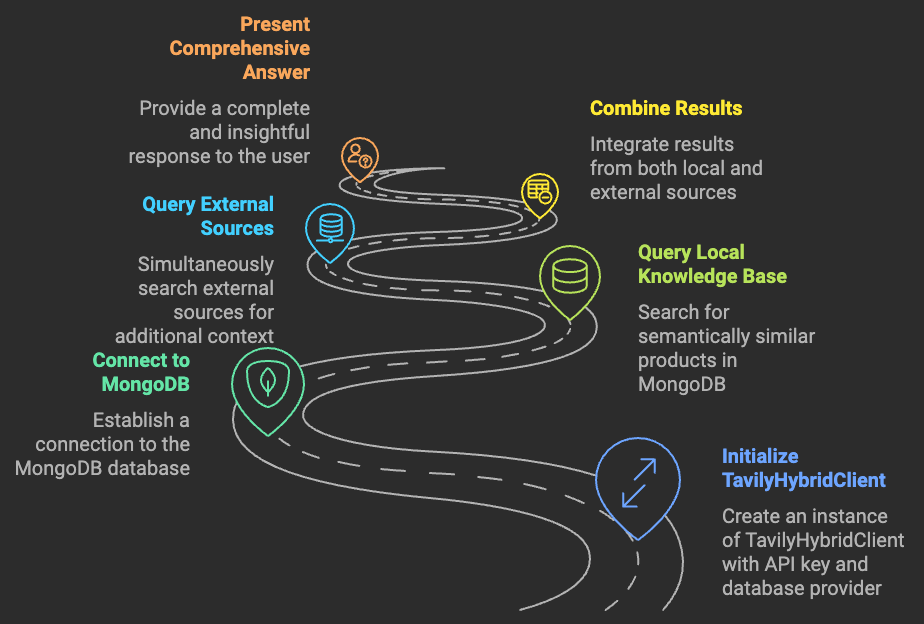

## Step 6: Tavily Hybrid RAG Client setup​ (Working Memory)



The code snippet below initializes the Tavily Hybrid RAG Client, which is the core component responsible for implementing working memory in AI sales assistants. It imports necessary libraries (`pymongo` and `tavily`) and then creates an instance of the `TavilyHybridClient` class.

During initialization, it configures the client with the Tavily API key, specifies MongoDB as the database provider, and provides references to the MongoDB collection, vector search index, embedding field, and content field.

This setup establishes the connection between Tavily and the underlying knowledge base, enabling the client to perform a hybrid search and manage working memory effectively.


In [22]:
# Set up Tavily API Key
set_env_securely("TAVILY_API_KEY", "Enter your Tavily API Key: ")

Enter your Tavily API Key: ··········


In [23]:
from pymongo import MongoClient
from tavily import TavilyHybridClient

hybrid_rag = TavilyHybridClient(
    api_key=os.environ.get("TAVILY_API_KEY"),
    db_provider="mongodb",
    collection=product_collection,
    index=vector_search_index_name,
    embeddings_field="embedding",
    content_field="product_semantics",
)

## Step 7: Retrieving Data From Working Memory (Real Time Search)

In [24]:
results = hybrid_rag.search(
    "Get me a black laptop to use in a office", max_local=5, max_foreign=2
)

In [25]:
# Create dataframe from the result and view as table
pd.DataFrame(results)

,content,score,origin
0,Black Laptop Computers at Office Depot & Offic...,9.982109e-01,foreign
1,Actual charge time will vary based on operatin...,8.951567e-01,foreign
2,"Dacasso Rosewood and Leather Desk Set, 10-Piec...",4.231559e-05,local
3,"Barker Creek Chevron Black Tie Affair, 30-Coun...",2.501950e-06,local
4,"Amscan 241143 Party Décor, Assorted Sizes, Bla...",4.280341e-07,local
5,Wholesale Boutique Wool Floppy Hat Black Toys ...,2.345434e-07,local
6,3 Row - Black with White Game Card Box Toys & ...,1.152039e-07,local


## Step 8: Save Short Term Memory Content to Long Term Memory

There are scenarios where storing new information from the working memory into a long-term memory component within a system is required.

For example. let's assume the user asks for "a black laptop with a long battery life for office use." Tavily might retrieve information about a specific laptop model with long battery life from an external website. By saving this foreign data, the next time a user asks for a "laptop with long battery life", the AI sales assistant can directly retrieve the previously saved information from its local knowledge base, providing a faster and more efficient response.


Below are a few more benefits and rationale for saving foreign data from working memory:

- Enriched Knowledge Base: By saving foreign data, the AI sales assistant's knowledge base becomes more comprehensive and up-to-date with information from the web. This can significantly improve the relevance and accuracy of future responses.
- Reduced Latency: Subsequent searches for similar queries will be faster as the relevant information is now available locally, eliminating the need to query external sources again. This also reduced the operational cost of the entire system.
- Offline Access: If external sources become unavailable, the AI sales assistant can still provide answers based on the previously saved foreign data, ensuring continuity of service.

In [26]:
results = hybrid_rag.search(
    "Get me a black laptop to use in a office",
    max_local=5,
    max_foreign=2,
    save_foreign=True,
)

In [27]:
pd.DataFrame(results)

,content,score,origin
0,Black Dell Laptops and 2-in-1 PCs Black Dell L...,7.009972e-01,foreign
1,"HP Stream 14"" HD BrightView Laptop, Intel Cele...",6.075190e-02,foreign
2,"Dacasso Rosewood and Leather Desk Set, 10-Piec...",4.231559e-05,local
3,"Barker Creek Chevron Black Tie Affair, 30-Coun...",2.501950e-06,local
4,"Amscan 241143 Party Décor, Assorted Sizes, Bla...",4.247031e-07,local
5,Wholesale Boutique Wool Floppy Hat Black Toys ...,2.327181e-07,local
6,3 Row - Black with White Game Card Box Toys & ...,1.152039e-07,local


Take note that the item with the content:

- "Black Dell Laptops and 2-in-1 PCs Black Dell L..."
- "HP Stream 14" HD BrightView Laptop, Intel Cele..."

are both sourced from the internet or a "foreign" source

In [28]:
results = hybrid_rag.search(
    "Get me a black laptop to use in a office",
    max_local=5,
    max_foreign=2,
    save_foreign=True,
)

In [29]:
pd.DataFrame(results)

,content,score,origin
0,Buy Black Business Laptops at Staples and get ...,9.981030e-01,foreign
1,Black Dell Laptops and 2-in-1 PCs Black Dell L...,6.999727e-01,local
2,"ASUS 2022 Laptop L210 11.6"" Ultra Thin Student...",6.465349e-02,foreign
3,"HP Stream 14"" HD BrightView Laptop, Intel Cele...",6.086345e-02,local
4,"Dacasso Rosewood and Leather Desk Set, 10-Piec...",4.231559e-05,local
5,"Barker Creek Chevron Black Tie Affair, 30-Coun...",2.501950e-06,local
6,"Amscan 241143 Party Décor, Assorted Sizes, Bla...",4.280341e-07,local


Observe that included in the "local" sourced results are search results that were once "foreign".

Items from used in the working memory, has been moved to the long term memory

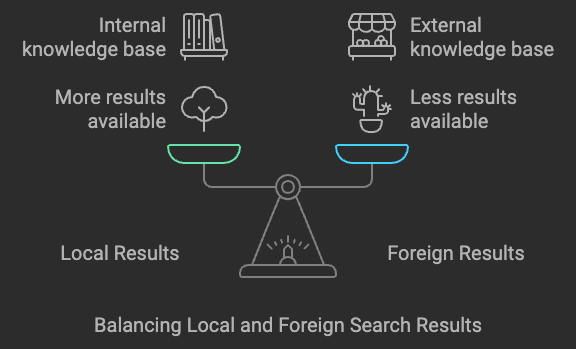

## Benefits of Working Memory For AI Agents and Agentic Systems


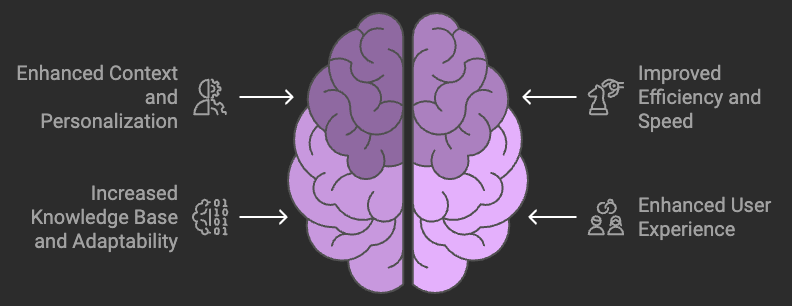

Working memory, enabled by Tavily and MongoDB in your AI application stack, offers several key benefits for LLM-powered chatbots, AI agents, and agentic systems, including AI-powered sales assistants:

1. Enhanced Context and Personalization: AI agents can remember past interactions and user preferences, allowing them to provide more contextually relevant and personalized responses. This is demonstrated in the code through the use of the Tavily Hybrid RAG Client, which stores and retrieves information from both local and foreign sources, allowing the system to recall past interactions.

2. Improved Efficiency and Speed: Working memory allows AI agents to access previously retrieved information quickly, reducing the need for repeated external queries. This is evident in the code where the `save_foreign=True` parameter enables saving foreign data into the local knowledge base, accelerating future searches for similar information.

3. Increased Knowledge Base and Adaptability: By saving foreign data, AI agents can continuously expand their knowledge base, learning from new interactions and adapting to evolving user needs. This is reflected in the code's use of MongoDB as a long-term memory store, enabling the system to build a more comprehensive knowledge base over time.

4. Enhanced User Experience: Working memory enables more natural and engaging interactions, as AI agents can understand and respond to user queries with greater context and personalization. This is a crucial benefit highlighted in the AI sales assistant use case, where remembering past interactions leads to more satisfying customer experiences.

Overall, working memory empowers AI agents and agentic systems to become more intelligent, adaptable, reliable, and user-centric, significantly improving their adoption, effectiveness, and overall user experience.
